In [1]:
import tensorflow as tf
import re
import gensim
import numpy as np
import pydot
import os
import json

from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Dropout, CuDNNLSTM, Input, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import plot_model

from gensim.models.wrappers import FastText

from AttentionWeightedAverage import AttentionWeightedAverage

Using TensorFlow backend.


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
pres = ['hoover', 'fdroosevelt', 'truman', 'hayes', 'adams', 'carter', 'madison', 'ford', 'cleveland', 'obama', 'harding', 'wilson', 'taylor', 'monroe', 'lincoln', '.ipynb_checkpoints', 'jefferson', 'vanburen', 'jackson', 'washington', 'polk', 'bush', 'gwbush', 'pierce', 'reagan', 'garfield', 'mckinley', 'coolidge', 'roosevelt', 'fillmore', 'johnson', 'harrison', 'taft', 'lbjohnson', 'jqadams', 'tyler', 'clinton', 'kennedy', 'eisenhower', 'nixon', 'arthur', 'grant', 'buchanan', 'bharrison']

file_train = ''
file_val = ''
file_test = ''

for root, dirs, files in os.walk("../1.DataPreparationResults", topdown=False):

    for name in files:
        file = os.path.join(root, name)
        
        if root.split('/')[2] in pres:
            text = open(file).read()
            
            if 'train' in file:
                file_train += text
            elif 'val' in file:
                file_val += text
            elif 'test' in file:
                file_test += text 

# Write to the 2.GPT2 XLNET folder
dir_split = "../1.DataPreparationResults/combined_data"
open(f"{dir_split}/train.txt", 'w').write(file_train)
open(f"{dir_split}/val.txt", 'w').write(file_val)
open(f"{dir_split}/test.txt", 'w').write(file_test)

6465277

In [4]:
# This essentially is to produce a unique words list from all the text before splitting into sentences

def google_preprocess(file):
    file2 = re.sub('\d', '#', file)
    file2 = re.sub(' a ', ' A ', file2)
    file2 = re.sub(' and ', ' And ', file2)
    file2 = re.sub(' of ', ' Of ', file2)
    file2 = re.sub(' to ', ' To ', file2)
    # Add spaces around <speech_sep>
    # Create a set of all words in file.txt but remove <speech_sep>
    unique_words = set(file2.replace("<speech_sep>", " <speech_sep> ").split())
    unique_words.remove("<speech_sep>")
    return file2, unique_words

file_train_google, unique_words_train = google_preprocess(file_train)
file_val_google, unique_words_val = google_preprocess(file_val)
file_test_google, unique_words_test = google_preprocess(file_test)

unique_words_all = unique_words_train.union(unique_words_val.union(unique_words_test))
print("total number of unique words: ",len(unique_words_all))

total number of unique words:  38013


In [5]:
x_len = 30
x_step = 1

def file_to_rolling_sentences(file):
    sentences = []
    sentences2 = []
    next_words = []
    list_words = []
    
    for speech in file.split("<speech_sep>"):
        list_words = speech.split()
        # I noticed the last speech has zero word 
        # because <speech_sep> is the last character
        if len(list_words) == 0:
            break
        
        # each row should have x_len + 1 (both input and target)
        for i in range(0,len(list_words)-x_len-1, x_step):
            sentences2 = [word for word in list_words[i: i + x_len + 1]]
            sentences.append(sentences2)
            
    return sentences

# train_sentences = file_to_sentences(file_train)
train_sentences = file_to_rolling_sentences(file_train_google)
val_sentences = file_to_rolling_sentences(file_val_google)

In [6]:
def file_to_each_sentence(file):
    
    sentence_all = []
    
    for speech in file.split("<speech_sep>"):
        sentences = speech.split('.')
        
        for sentence in sentences:
            sentence_all.append(sentence.strip() + '.')
    
    return sentence_all

train_sentences = file_to_each_sentence(file_train_google)
val_sentences = file_to_each_sentence(file_val_google)

In [7]:
number_words = 25
maxlength = 50

tokenizer = Tokenizer(nb_words=number_words)
tokenizer.fit_on_texts(train_sentences)
tokenized_sequences = tokenizer.texts_to_sequences(train_sentences)

/home/tennisonyu/anaconda3/envs/w266-lstm/lib/python3.7/site-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [8]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 23752 unique tokens.


In [9]:
index_word = new_dict = dict([(value, key) for key, value in word_index.items()]) 

In [10]:
train_data = pad_sequences(tokenized_sequences, maxlen=maxlength)

In [11]:
train_x = train_data[:, :-1]
train_y = train_data[:, -1]

In [12]:
tokenized_val = tokenizer.texts_to_sequences(val_sentences)
val_data = pad_sequences(tokenized_val, maxlen=maxlength)
val_x = val_data[:, :-1]
val_y = val_data[:, -1]

### Prepare Word Embeddings

In [13]:
google_word_model = gensim.models.KeyedVectors.load_word2vec_format('../../test/GoogleNews-vectors-negative300.bin', binary=True)


In [14]:
#get all the vectors
#pretrained_weights = google_word_model.wv.vectors

#word2idx
def word2idx(word):
    return google_word_model.wv.vocab[word].index
    

#idx2word
def idx2word(idx):
    return google_word_model.wv.index2word[idx]

#get vector of word
#google_word_model["Hi"]

In [15]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = google_word_model[word] if word in google_word_model else None
    
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [33]:
model = tf.keras.Sequential()

inputs = Input(shape=(49,))

embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=maxlength-1, trainable=False)(inputs)
lstm1 = LSTM(units = 300, return_sequences = True)(embedding_layer)
lstm2 = LSTM(units = 300, return_sequences = True)(lstm1)
predictions = Dense(len(word_index), activation='softmax')(lstm2)


#test = Concatenate(axis=1)([embedding_layer, lstm1, lstm2])
#custom_layer = AttentionWeightedAverage(name='attention')(test)

model = Model(inputs=inputs,outputs=predictions)

# model.add(embedding_layer)
# model.add(LSTM(units = 128, return_sequences = True))
# model.add(LSTM(units = 128, return_sequences = True))
# model.add(Dense(len(word_index), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#print(model.summary())
#plot_model(model)

In [17]:
# model = tf.keras.Sequential()
# model.add(embedding_layer)
# model.add(LSTM(EMBEDDING_DIM))
# model.add(Dense(64))
# model.add(Dropout(0.2))
# model.add(Dense(64))
# model.add(Dropout(0.2))
# model.add(Dense(len(word_index), activation='softmax'))

# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 32, 300)           7125900   
_________________________________________________________________
lstm_6 (LSTM)                (None, 32, 300)           721200    
_________________________________________________________________
lstm_7 (LSTM)                (None, 32, 300)           721200    
_________________________________________________________________
dense_3 (Dense)              (None, 32, 23752)         7149352   
Total params: 15,717,652
Trainable params: 8,591,752
Non-trainable params: 7,125,900
_________________________________________________________________


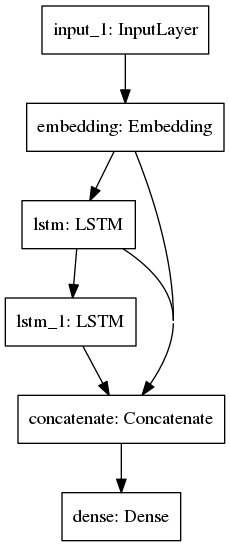

In [19]:
plot_model(model)

In [20]:
def sample(preds, temperature=1.0):
    if temperature <= 0:
        return np.argmax(preds)
    
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    
    return np.argmax(probas)


def generate_next(text, num_generated=10):
    tokenized_sequences = [word_index[word] for word in text.lower().split() if word in word_index.keys()]
    #tokenized_sequences = [word2idx(word) for word in text.lower().split() if word in google_word_model]
        
    padded_sequences = pad_sequences([tokenized_sequences], maxlen=maxlength)[:, 1:]
    
    print(padded_sequences)
    
    
    for i in range(num_generated):
        #print(padded_sequences.shape)
        prediction = model.predict(x=padded_sequences)
        idx = sample(prediction[-1], temperature=0.7)
        
        tokenized_sequences = np.append(tokenized_sequences, idx)
        padded_sequences = pad_sequences([tokenized_sequences], maxlen=maxlength)[:, 1:]
        
    return ' '.join([index_word[idx] for idx in padded_sequences[0] if idx != 0])
    #return ' '.join([idx2word(idx) for idx in padded_sequences[0] if idx != 0])

def on_epoch_end(epoch, _):
    #print('\nGenerating text after epoch: %d' % epoch)
    
    texts = ["There are two ways to love you"]
    
    for text in texts:
        sample = generate_next(text)
        print('%s... -> %s' % (text, sample))

In [21]:
val_x.shape

(41905, 49)

In [34]:
history = model.fit(train_x, train_y, epochs=30, batch_size=32, validation_data=(val_x, val_y)) #, callbacks=[LambdaCallback(on_epoch_end=on_epoch_end)])

Train on 52407 samples, validate on 41905 samples
Epoch 1/30


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: Incompatible shapes: [32,49] vs. [32]
	 [[{{node metrics_8/acc/Equal}}]]
	 [[loss_4/mul/_531]]
  (1) Invalid argument: Incompatible shapes: [32,49] vs. [32]
	 [[{{node metrics_8/acc/Equal}}]]
0 successful operations.
0 derived errors ignored.

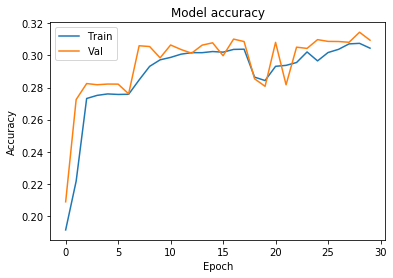

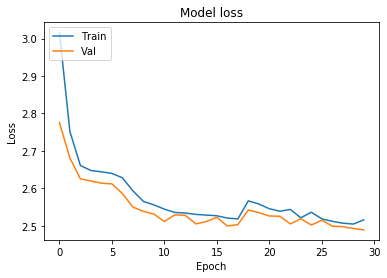

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [24]:
generate_next("Hello How are you")

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0 10852   224    20
     40]]


'hello how are you to and and the in the of by be to'

In [26]:
with open('train_history_sentence_style_google_w2v_embedtrain_F.json', 'w') as f:
    json.dump(str(history.history), f)